# Sandbox for Exploring Tests 

## Load Libraries

In [1]:
# Data libraries 
import pandas as pd

# ML libraries
from numpy import argmax
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron
from arch.unitroot import ZivotAndrews
from arch.unitroot import DFGLS
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ValidMind libraries 
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import validmind as vm
from validmind.vm_models.test_context import TestContext

In [2]:
# Quick hack to load local library code
import os
os.chdir(os.path.join(os.getcwd(), ".."))
# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [1]:
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

def summary_to_df(summary):
    # Extract tables from the summary
    tables = summary.tables

    # The first table is a SimpleTable object and contains model-level statistics
    model_stats = tables[0].data
    model_stats_headers = model_stats.pop(0)
    model_stats_df = pd.DataFrame(model_stats, columns=model_stats_headers)

    # The second table is also a SimpleTable object and contains coefficient-level statistics
    coef_stats = tables[1].data
    coef_stats_headers = coef_stats.pop(0)
    coef_stats_df = pd.DataFrame(coef_stats, columns=coef_stats_headers)

    return model_stats_df, coef_stats_df


model_stats_df, coef_stats_df = summary_to_df(model_summary)


## Load Data

In [6]:
df = pd.read_csv("/Users/juanvalidmind/Dev/github/validmind/validmind-python/notebooks/datasets/lending_club_loan_rates.csv", sep='\t')
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.set_index(pd.to_datetime(df['Date']))
df.drop(["Date"], axis=1, inplace=True)

# Remove diff columns
columns_to_remove = [col for col in df.columns if col.startswith("diff")]
df = df.drop(columns=columns_to_remove)
df.head()

,loan_rate_A,loan_rate_B,loan_rate_C,loan_rate_D,FEDFUNDS
Date,,,,,
2007-08-01,7.766667,9.497692,10.947500,12.267000,5.02
2007-09-01,7.841429,9.276667,10.829167,12.436667,4.94
2007-10-01,7.830000,9.433333,10.825926,12.737368,4.76
2007-11-01,7.779091,9.467778,10.967037,12.609444,4.49
2007-12-01,7.695833,9.387500,10.805000,12.478889,4.24


## ValidMind Setup

In [5]:
vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "...",
  api_secret = "...",
  project = "..."
)

True

In [7]:
target_variables = ["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column = target_variables   
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


In [8]:
vm.test_plans.list_plans()

ID,Name,Description
sklearn_classifier_metrics,SKLearnClassifierMetrics,Test plan for sklearn classifier metrics
sklearn_classifier_validation,SKLearnClassifierPerformance,Test plan for sklearn classifier models
sklearn_classifier,SKLearnClassifier,Test plan for sklearn classifier models that includes both metrics and validation tests
tabular_dataset,TabularDataset,Test plan for generic tabular datasets
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets
normality_test_plan,NormalityTestPlan,Test plan to perform normality tests.
autocorrelation_test_plan,AutocorrelationTestPlan,Test plan to perform autocorrelation tests.
seasonality_test_plan,SesonalityTestPlan,Test plan to perform seasonality tests.
unit_root_test_plan,UnitRootTestPlan,Test plan to perform unit root tests.


**Create Train and Test Datasets**

In [9]:
test_size = 30
train_ds = df[:-test_size]
test_ds = df[-test_size:]

In [11]:
vm_train_ds = vm.init_dataset(dataset=train_ds, type="generic")
vm_test_ds = vm.init_dataset(dataset=test_ds, type="generic")
vm_dataset = vm.init_dataset(dataset=df, type="generic")

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


## Augmented Dickie-Fuller Test

**Original**

In [ ]:
adftest = adfuller(df['loan_rate_A'])
adftest

(-1.917289312690944,
 0.32397189281015515,
 1,
 135,
 {'1%': -3.479742586699182,
  '5%': -2.88319822181578,
  '10%': -2.578319684499314},
 -71.08908853191068)

**ValidMind**

In [13]:
from validmind.model_validation.statsmodels.metrics import ADF
test_context = TestContext(dataset=vm_dataset)
metric = ADF(test_context=test_context)
metric.run()

TestSuiteMetricResult(figures=None, metric=MetricResult(type='evaluation', scope='test', key='adf', value={'loan_rate_A': {'stat': -1.917289312690944, 'pvalue': 0.32397189281015515, 'usedlag': 1, 'nobs': 135, 'critical_values': {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}, 'icbest': -71.08908853191068}, 'loan_rate_B': {'stat': -3.1599303710498425, 'pvalue': 0.022424413263559147, 'usedlag': 9, 'nobs': 127, 'critical_values': {'1%': -3.482920063655088, '5%': -2.884580323367261, '10%': -2.5790575441750883}, 'icbest': -42.45027033820841}, 'loan_rate_C': {'stat': -2.530666699941385, 'pvalue': 0.10818994357289696, 'usedlag': 1, 'nobs': 135, 'critical_values': {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}, 'icbest': -92.19465856666866}, 'loan_rate_D': {'stat': -1.617158531178829, 'pvalue': 0.47421928207593467, 'usedlag': 6, 'nobs': 130, 'critical_values': {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.5787700

## KPSS Test

**Original**

In [11]:
kpsstest = kpss(df['loan_rate_A'])
kpsstest

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



(1.012356679488042,
 0.01,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

**ValidMind**

In [12]:
from validmind.model_validation.statsmodels.metrics import KPSSTest
test_context = TestContext(train_ds=vm_train_ds)
metric = KPSSTest(test_context=test_context)
metric.run()

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-va

TestSuiteMetricResult(figures=None, metric=MetricResult(type='evaluation', scope='test', key='kpss', value={'stat': 0.06862873540051123, 'pvalue': 0.1, 'usedlag': 8}, value_formatter='key_values'))

## Phillips-Perron (PP) Test

**Original**

In [13]:
pp = PhillipsPerron(df['loan_rate_A'])
pp

Test Statistic,-2.027
P-value,0.275
Lags,13


In [14]:
pp.nobs

136

**ValidMind**

## Zivot-Andrews Test

**Original**

In [15]:
za = ZivotAndrews(df['loan_rate_A'])
za

Test Statistic,-3.499
P-value,0.680
Lags,1


In [16]:
za.nobs

137

**ValidMind**

## Dickey-Fuller GLS Test

**Original**

In [17]:
dfgls = DFGLS(df['loan_rate_A'])
dfgls


Test Statistic,-1.798
P-value,0.071
Lags,1


In [18]:
dfgls.nobs

135

**ValidMind**

## Seasonal Decomposition

**Off ValidMind**

In [19]:
sd = seasonal_decompose(df['loan_rate_A'])
sd

In [20]:
sd.trend

Date
2007-08-01   NaN
2007-09-01   NaN
2007-10-01   NaN
2007-11-01   NaN
2007-12-01   NaN
              ..
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
2018-11-01   NaN
2018-12-01   NaN
Name: trend, Length: 137, dtype: float64

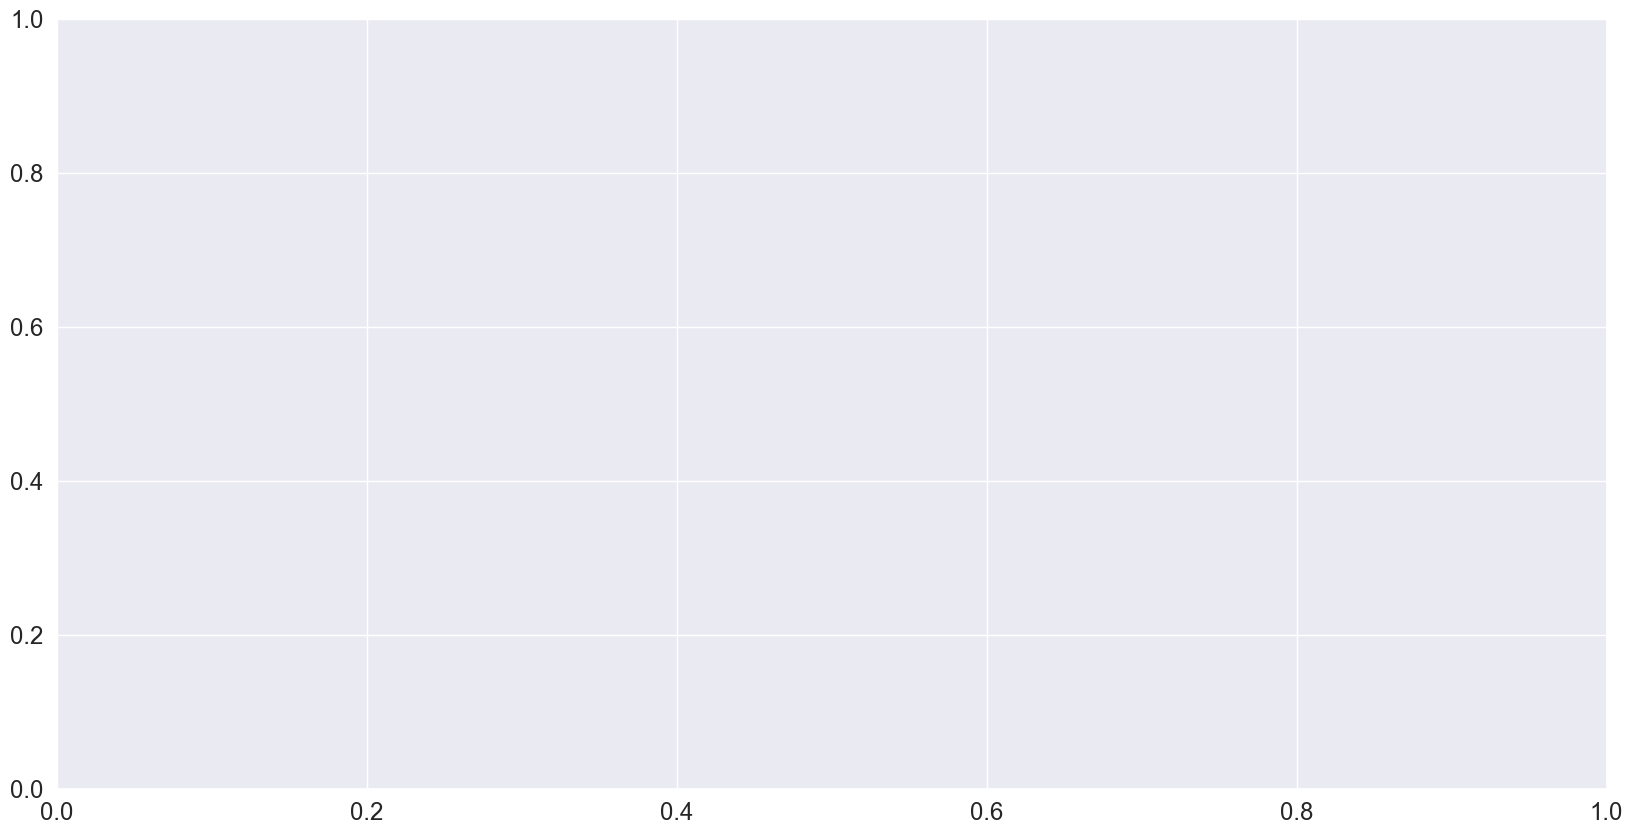

In [21]:
fig, ax = plt.subplots()

**In ValidMind**

In [22]:
from validmind.model_validation.statsmodels.metrics import SeasonalDecomposeMetricWithFigure
test_context = TestContext(train_ds=vm_train_ds)
sd_metric = SeasonalDecomposeMetricWithFigure(test_context=test_context)
sd_metric.run()

TestSuiteMetricResult(figures=[Figure(key='seasonal_decomposition_with_figure', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None)], metric=MetricResult(type='evaluation', scope='', key='seasonal_decomposition_with_figure', value={'loan_rate_A': [{'date': '2007-08-01', 'trend': nan, 'seasonal': -0.050284773390468294, 'resid': nan, 'observed': 7.7666666666666675}, {'date': '2007-09-01', 'trend': nan, 'seasonal': -0.06087962072801919, 'resid': nan, 'observed': 7.841428571428572}, {'date': '2007-10-01', 'trend': nan, 'seasonal': 0.01749661199350142, 'resid': nan, 'observed': 7.83}, {'date': '2007-11-01', 'trend': nan, 'seasonal': -0.047258378330469496, 'resid': nan, 'observed': 7.779090909090908}, {'date': '2007-12-01', 'trend': nan, 'seasonal': 0.0850517814632488, 'resid': nan, 'observed': 7.695833333333333}, {'date': '2008-01-01', 'trend': nan, 'seasonal': 0.06564185816692857, 'resid': nan, 'observed': 7.961333333333333}, {'date': '2008-02-01', 'trend': 8.005048767959

## Residuals Visual Inspection

**Off ValidMind**

In [23]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(df['loan_rate_A'], model="additive") 
residuals = sd.resid

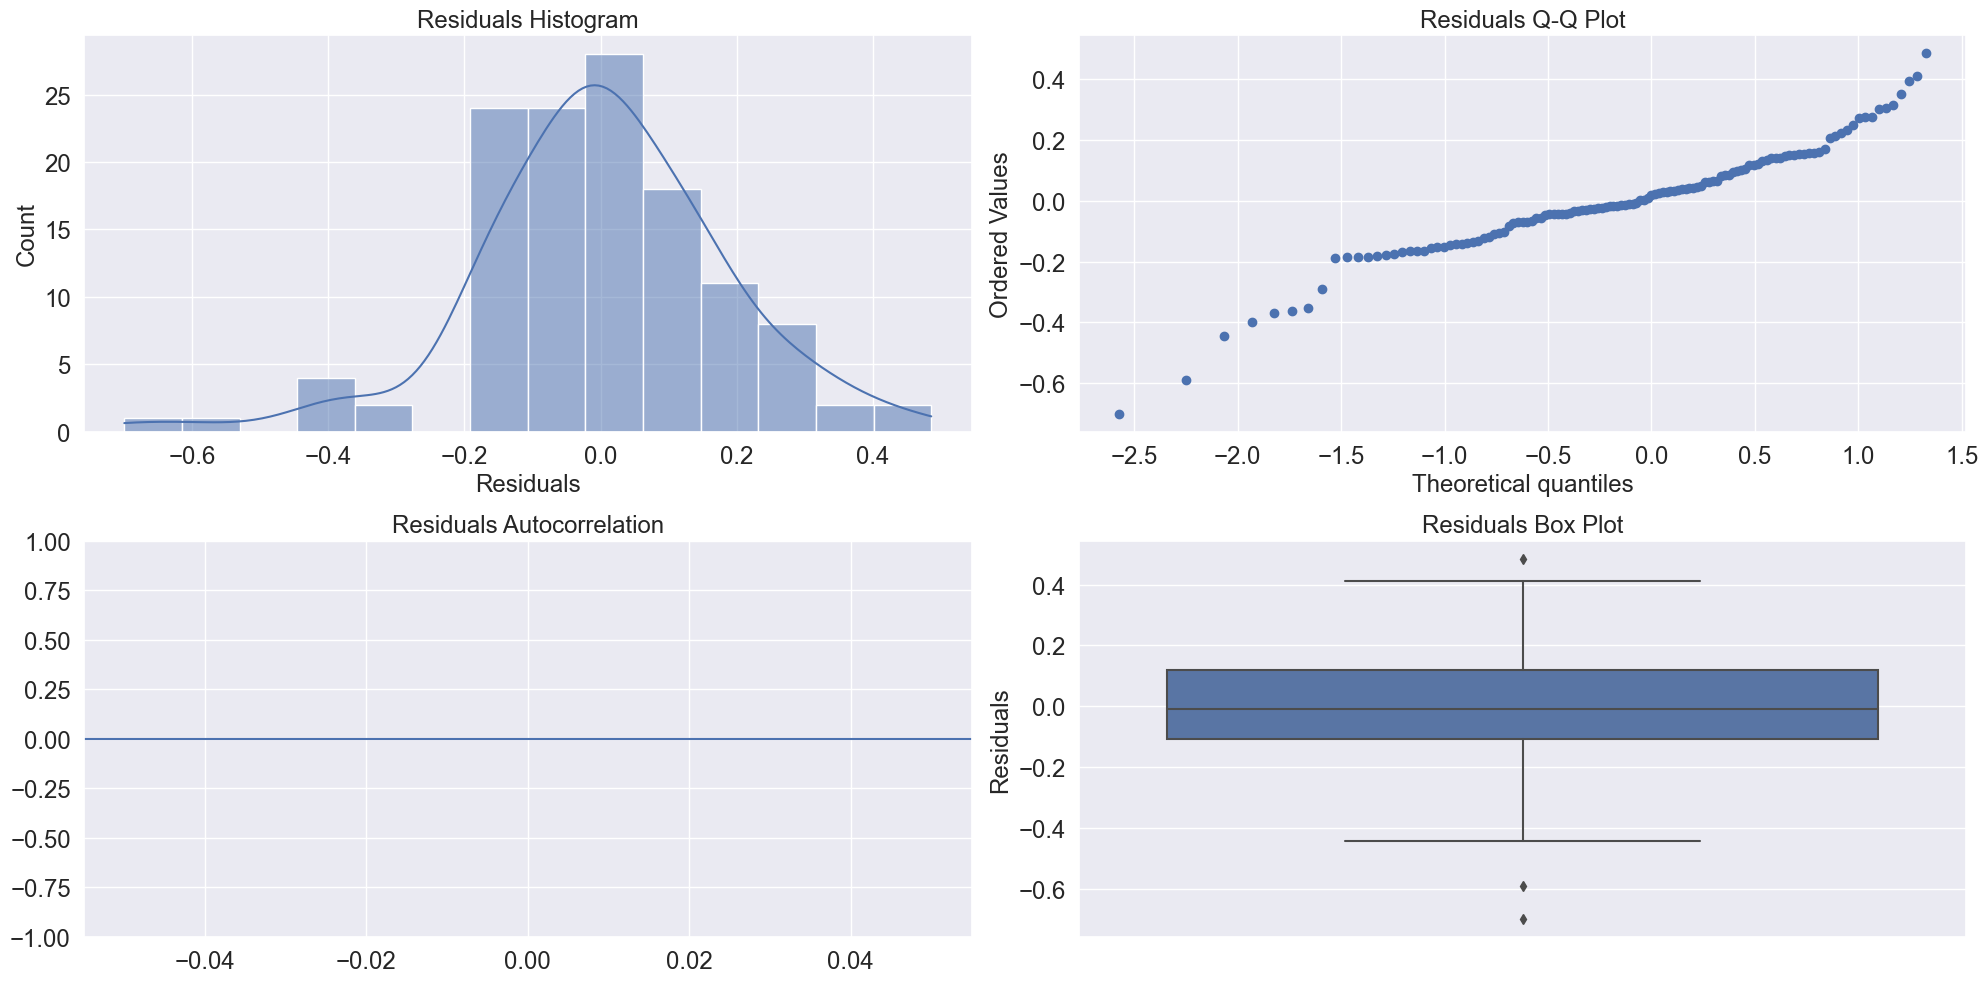

In [24]:
 # Create subplots
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(nrows=2, ncols=2)

# Plot 1: Residuals histogram
sns.histplot(residuals, kde=True, ax=axes[0, 0])
axes[0, 0].set_xlabel("Residuals")
axes[0, 0].set_title("Residuals Histogram")

# Plot 2: Residuals Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Residuals Q-Q Plot")

# Plot 3: Residuals autocorrelation plot
plot_acf(residuals, ax=axes[1, 0], lags=100)
axes[1, 0].set_title("Residuals Autocorrelation")

# Plot 4: Residuals box plot
sns.boxplot(y=residuals, ax=axes[1, 1])
axes[1, 1].set_ylabel("Residuals")
axes[1, 1].set_title("Residuals Box Plot")

# Adjust the layout
plt.tight_layout()

**In ValidMind**

In [25]:
from validmind.model_validation.statsmodels.metrics import ResidualsVisualInspection
test_context = TestContext(train_ds=vm_train_ds)
rvi_test = ResidualsVisualInspection(test_context=test_context)
rvi_test.run()

TestSuiteMetricResult(figures=[Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Fi

In [26]:
rvi_test.result.figures

[Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None),
 Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None),
 Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None),
 Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None),
 Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None),
 Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None),
 Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None),
 Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None),
 Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 wi

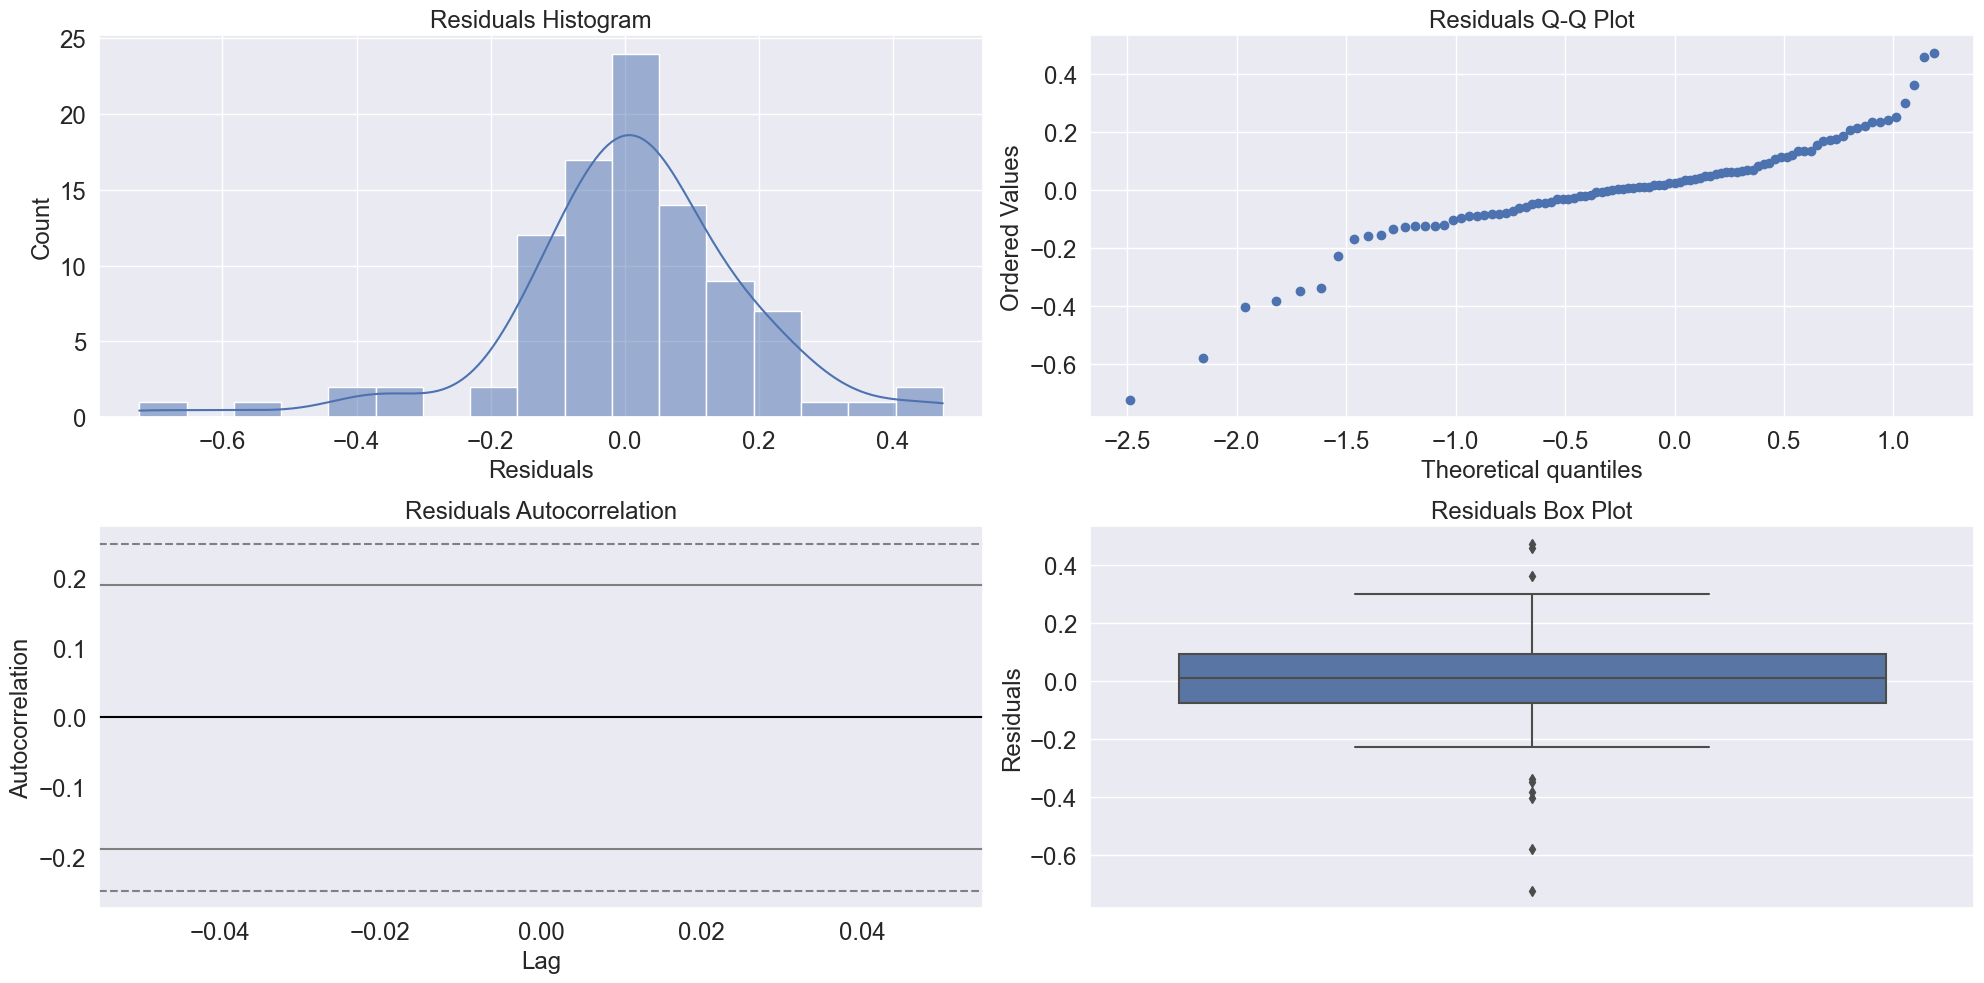

In [27]:
rvi_test.result.figures[0].figure

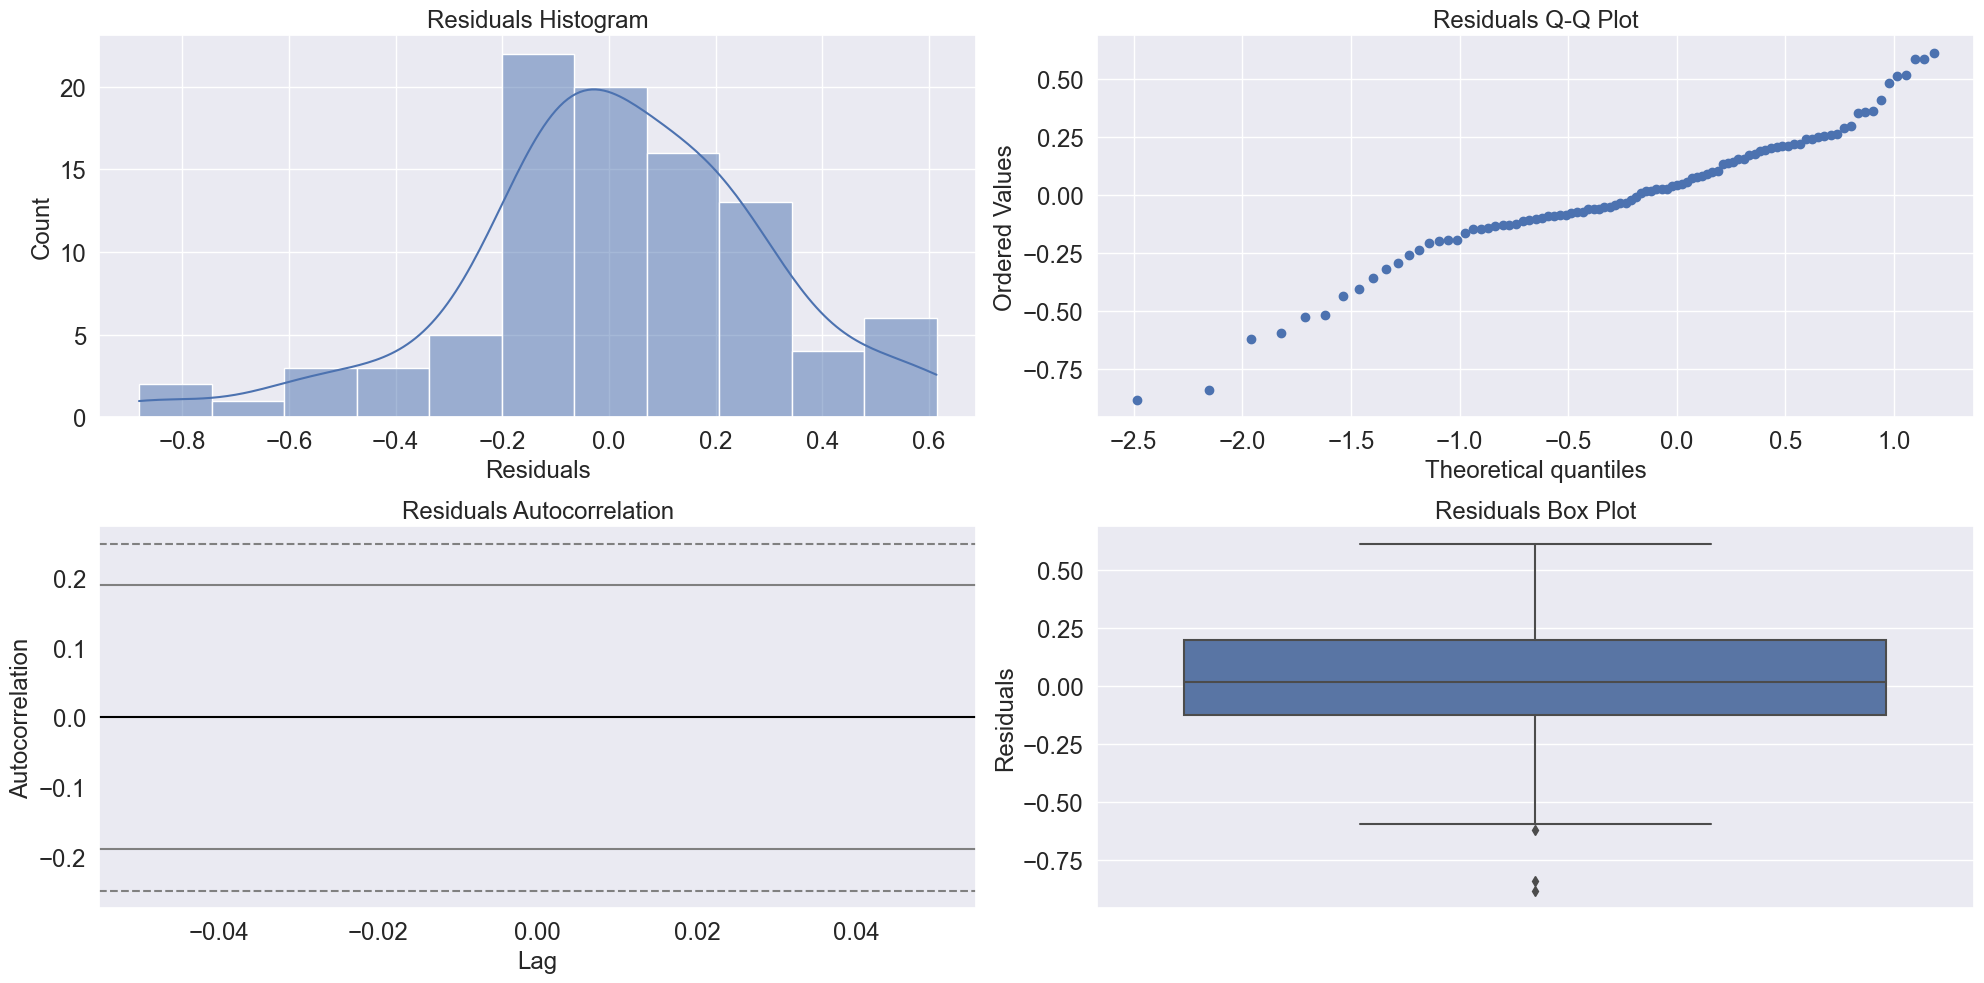

In [28]:
rvi_test.result.figures[1].figure